# T2: Training UNET for Segmentation of Echocardiograms

## Pre-processing

In [4]:
'''
Pre-processing ultrasound videos'''

import cv2
from pathlib import Path 

#video_directory = the directory with the echonet videos
#frame_output_directory = the directory where the frames for each video will be saved
#video extensions = the echonet uss video ext.
video_directory = Path(r"EchoNet-Dynamic/Videos")
frame_output_directory = Path(r"EchoNet-Dynamic/frame_outputs")
VIDEO_EXTENSIONS = {".avi"}

#create a directory if it doesn't exist already
frame_output_directory.mkdir(parents=True, exist_ok= True) 

#this function extracts the frames from the video
def extract_frames_from_videos(videofile: Path, output_directory: Path):
    capture = cv2.VideoCapture(str(videofile))
    if not capture.isOpened(): #if the ultrasound file is not opened then print error
        print(f"Error: {videofile} couldn't be opened. Troubleshoot.")
        return 0 #returns 0 frames -- i.e video frames not captured
    
    #create an output directory if it doesn't exist for the frames
    output_directory.mkdir(parents=True, exist_ok=True)
    
    frame_count = 0
    while True: #infinitely loop over the videos read in
        '''return a boolean value called videoHasFrame and frame 
        which is a frame/image from the video
        '''
        videoHasFrame, frame = capture.read() 
        #videoHasFrame is a boolean value that returns true if the 
        #video frame has been read
        #so if 
        if not videoHasFrame:
            break #stop the operation because there's something wrong
        
        '''if it's read then all good continue
        but according to Geeks4geeks, even if u/s vids are grayscale
        it's good to enforce pre-processing pipelines
        just because it's good to be able to reuse code for
        other files that may have colour doppler as input'''
        gray_frames = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray_frames, (112, 112), interpolation=cv2.INTER_AREA)
        ''' the code below is to makesure that the frames
        extracted and outputted into the directory have the following structure
        frame__[number].png and they are placed in the corresponding
        directory which has the filename because that prevents
        leaking or swapping of the frames between each video files'''
        cv2.imwrite(str(output_directory / f"frame_{frame_count:04d}.png"), resize)
        frame_count += 1
    capture.release()
    return frame_count



def run_video_frame_extraction(video_directory:Path, output_directory:Path):
    videos = [video for video in video_directory.rglob("*") if video.is_file() and video.suffix.lower() in VIDEO_EXTENSIONS]
    
    #check to see if there's no vids
    if not videos:
        print("No vids found")
        return
    
    total_frames = 0
    for video in videos:
        # Create subfolder for each video
        video_output_dir = output_directory / video.stem
        frames = extract_frames_from_videos(video, video_output_dir)
        print(f"Extracted {frames} frames from {video.name}")
        total_frames += frames
    
    print(f"Total: {total_frames} frames from {len(videos)} videos")




## Run This to extract frame-- note it's been commented out to avoid triggering unecessarily

In [5]:
#run the extract and pre-process method:: this has been commented out
#run_video_frame_extraction(video_directory, frame_output_directory)

In [6]:
'''
Need to go through all the mask images and find the corresponding
frame for each video

By now, the folder structure should be
frames_directory/videoname/frame_xxxx.png  where xxxx = frame number
masks_directory/videoname/frame_xxxx.png where xxxx = frame numebr
'''
from pathlib import Path
#relative path to frames and masks root
frames_root = "EchoNet-Dynamic/frame_outputs"
masks_root = "EchoNet-Dynamic/output_masks_noncorrected"

def get_frame_mask_pairs(frames_root, masks_root, syntax = "frame_*.png"):
    frames_root = Path(frames_root)
    masks_root = Path(masks_root)
    
    #go through all the mask files
    mask_files = list(masks_root.rglob(syntax))
    
    #init  a list of pairs and missing_frames to check missing frames
    pairs = []
    missing_frames = []
    
    for mask_path in mask_files:
        #find the relative path
        relative_path = mask_path.relative_to(masks_root)
        
        #using the relative path look for the corresponding frame
        frame_path = frames_root / relative_path
        
        #if foudn sucessfuly then store the paths for the mask and corresp frame
        if frame_path.exists():
            pairs.append((str(frame_path), str(mask_path)))
        else: #add to the missing frames
            missing_frames.append(str(relative_path))
    
    print(f"Found {len(pairs)} of frame and mask pairs")
    print(f"Total masks are: {len(mask_files)}, if it doesn't match then troubleshoot")
    
    #check if there's missing frames for troubleshooting
    if missing_frames:
        print(f"{len(missing_frames)} missing frames for masks:")
        for missingframe in missing_frames[:5]:
            print(f"  {missingframe}")
    
    return pairs
        
            
    
pairs = get_frame_mask_pairs(frames_root, masks_root)




Found 20048 of frame and mask pairs
Total masks are: 20048, if it doesn't match then troubleshoot


In [7]:
'''Now time to retrieve the corresponding files based on the pairs of images and mask
and then split them to 0.7 train/ 0.15 val / 0.15 test based on the video
name so that each video can only be only be in either train/val/test and 
there's no cross contamination of the data, which can inflate metrics'''

import random
import shutil
from pathlib import Path
from collections import defaultdict

def split_pairs_by_video(pairs, output_dir="data_splitted", train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Split frame-mask pairs by VIDEO to prevent data leakage.
    all frames from the same video go to the same split.
    """
    
    # group pairs by video ID
    video_groups = defaultdict(list)
    
    for frame_path, mask_path in pairs:
        # extract video ID from frame path (parent folder name)
        video_id = Path(frame_path).parent.name
        video_groups[video_id].append((frame_path, mask_path))
    
    # split videos (not individual frames)
    video_ids = list(video_groups.keys())
    random.seed(42)  # Reproducible splits
    random.shuffle(video_ids)
    
    n_videos = len(video_ids)
    n_train = int(train_ratio * n_videos)
    n_val = int(val_ratio * n_videos)
    
    train_videos = set(video_ids[:n_train])
    val_videos = set(video_ids[n_train:n_train + n_val])
    test_videos = set(video_ids[n_train + n_val:])
    
    print(f"Video-level split: {len(train_videos)} train, {len(val_videos)} val, {len(test_videos)} test")
    
    # create output directories
    output_path = Path(output_dir)
    for split in ['train', 'val', 'test']:
        for data_type in ['frames', 'masks']:
            (output_path / split / data_type).mkdir(parents=True, exist_ok=True)
    
    # copy files by video group
    splits = {'train': train_videos, 'val': val_videos, 'test': test_videos}
    
    for split_name, video_set in splits.items():
        total_pairs = 0
        for video_id in video_set:
            # create video subdirectories
            frame_dir = output_path / split_name / 'frames' / video_id
            mask_dir = output_path / split_name / 'masks' / video_id
            frame_dir.mkdir(parents=True, exist_ok=True)
            mask_dir.mkdir(parents=True, exist_ok=True)
            
            # copy all frames/masks for this video
            for frame_path, mask_path in video_groups[video_id]:
                shutil.copy2(frame_path, frame_dir / Path(frame_path).name)
                shutil.copy2(mask_path, mask_dir / Path(mask_path).name)
                total_pairs += 1
        
        print(f"{split_name}: {total_pairs} pairs from {len(video_set)} videos")
    
    return splits

# perform the split -- uncomment this to use the function
#video_splits = split_pairs_by_video(pairs)


Total pairs found: 20048
Pair 1:
  Frame: EchoNet-Dynamic\frame_outputs\0X61D67DBEE3CA29C\frame_0078.png
  Mask:  EchoNet-Dynamic\output_masks_noncorrected\0X61D67DBEE3CA29C\frame_0078.png
  Video: 0X61D67DBEE3CA29C

Pair 2:
  Frame: EchoNet-Dynamic\frame_outputs\0X9A79C9B36D1055C\frame_0044.png
  Mask:  EchoNet-Dynamic\output_masks_noncorrected\0X9A79C9B36D1055C\frame_0044.png
  Video: 0X9A79C9B36D1055C

Pair 3:
  Frame: EchoNet-Dynamic\frame_outputs\0X5478D5A9213C8100\frame_0095.png
  Mask:  EchoNet-Dynamic\output_masks_noncorrected\0X5478D5A9213C8100\frame_0095.png
  Video: 0X5478D5A9213C8100

Pair 4:
  Frame: EchoNet-Dynamic\frame_outputs\0X57B578504088002B\frame_0057.png
  Mask:  EchoNet-Dynamic\output_masks_noncorrected\0X57B578504088002B\frame_0057.png
  Video: 0X57B578504088002B

Pair 5:
  Frame: EchoNet-Dynamic\frame_outputs\0X1D8D28801D701B6\frame_0019.png
  Mask:  EchoNet-Dynamic\output_masks_noncorrected\0X1D8D28801D701B6\frame_0019.png
  Video: 0X1D8D28801D701B6

Pair 6:
 

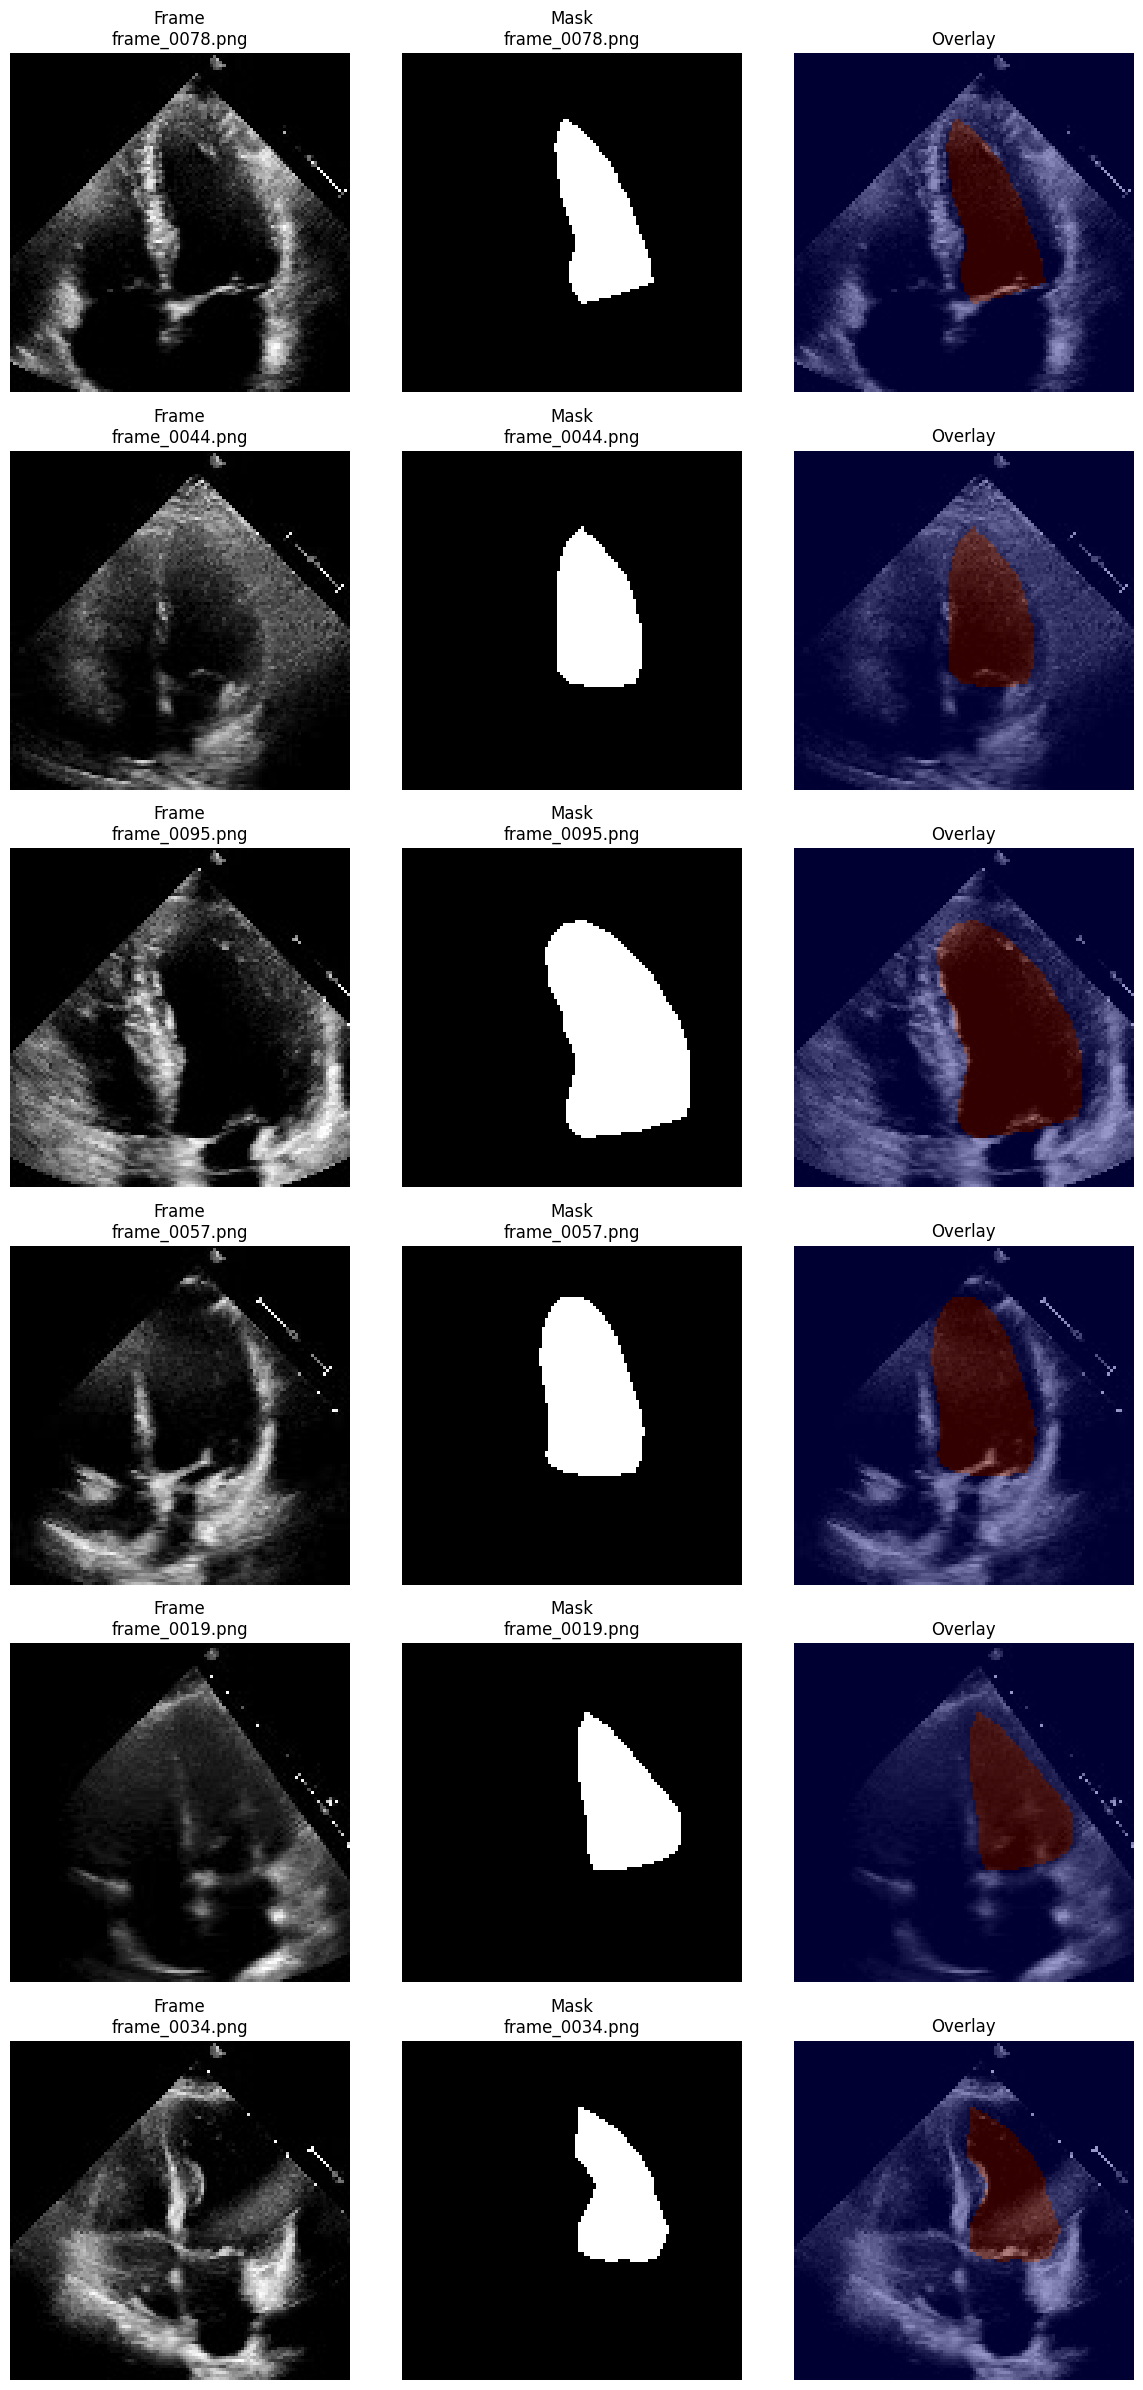

Checking alignment of 10 pairs...
OK pair 0: frame_0046.png (video: 0X100009310A3BD7FC)
OK pair 1: frame_0061.png (video: 0X100009310A3BD7FC)
OK pair 2: frame_0003.png (video: 0X1002E8FBACD08477)
OK pair 3: frame_0018.png (video: 0X1002E8FBACD08477)
OK pair 4: frame_0024.png (video: 0X1005D03EED19C65B)
OK pair 5: frame_0035.png (video: 0X1005D03EED19C65B)
OK pair 6: frame_0091.png (video: 0X10075961BC11C88E)
OK pair 7: frame_0108.png (video: 0X10075961BC11C88E)
OK pair 8: frame_0137.png (video: 0X10094BA0A028EAC3)
OK pair 9: frame_0156.png (video: 0X10094BA0A028EAC3)

All 10 checked pairs are aligned correctly!


In [8]:
'''Visualise the result to see if there's a stuff-up somewhere'''

import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import random

def visualize_frame_mask_pairs(pairs, num_pairs=6, random_sample=True):
    """
    Visualize frame-mask pairs to verify correct pairing.
    args:
        pairs: List of (frame_path, mask_path) tuples
        num_pairs: Number of pairs to display
        random_sample: If True, randomly sample pairs; if False, take first num_pairs
    """
    # check if we actually have pairs to work with
    if not pairs:
        print("No pairs to visualize!")
        return
    
    # cample pairs to display - either random selection or first few
    if random_sample:
        # Randomly pick pairs to get variety from different videos/frames
        display_pairs = random.sample(pairs, min(num_pairs, len(pairs)))
    else:
        # Just take the first few pairs in order
        display_pairs = pairs[:num_pairs]
    
    # Create subplot layout - each row shows one pair (frame, mask, overlay)
    # figsize makes it big enough to see details
    fig, axes = plt.subplots(len(display_pairs), 3, figsize=(12, 4*len(display_pairs)))
    
    # Handle case where only one pair - matplotlib behaves differently
    if len(display_pairs) == 1:
        axes = axes.reshape(1, -1)  # Make it 2D so indexing works
    
    # Loop through each selected pair and display them
    for i, (frame_path, mask_path) in enumerate(display_pairs):
        # Load images using OpenCV - GRAYSCALE because echocardiograms are grayscale
        frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Error handling - sometimes files might be corrupted or missing
        if frame is None or mask is None:
            print(f"Error loading pair {i}: {frame_path}, {mask_path}")
            continue
        
        # Display frame in first column
        axes[i, 0].imshow(frame, cmap='gray')  # grayscale colormap
        axes[i, 0].set_title(f'Frame\n{Path(frame_path).name}')
        axes[i, 0].axis('off')  # Remove axis ticks/labels for cleaner look
        
        # Display mask in second column
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title(f'Mask\n{Path(mask_path).name}')
        axes[i, 1].axis('off')
        
        # Display overlay in third column - frame as background, mask colored on top
        axes[i, 2].imshow(frame, cmap='gray')  # Background frame
        # Overlay mask with transparency (alpha=0.4) and color (jet colormap)
        # This helps see if mask aligns with actual heart structures
        axes[i, 2].imshow(mask, cmap='jet', alpha=0.4)
        axes[i, 2].set_title('Overlay')
        axes[i, 2].axis('off')
        
        # Print paths for debugging - helps verify files are from correct locations
        print(f"Pair {i+1}:")
        print(f"  Frame: {frame_path}")
        print(f"  Mask:  {mask_path}")
        print(f"  Video: {Path(frame_path).parent.name}")  # Video folder name
        print()
    
    # Make layout neat and show the plot
    plt.tight_layout()
    plt.show()

def check_pair_alignment(pairs, num_check=10):
    """
    Check if frame and mask pairs are properly aligned by comparing filenames.
    This is critical - misaligned pairs will train the model incorrectly!
    """
    print(f"Checking alignment of {min(num_check, len(pairs))} pairs...")
    
    # Counter for misaligned pairs
    misaligned = 0
    
    # Check first num_check pairs (don't need to check all thousands)
    for i, (frame_path, mask_path) in enumerate(pairs[:num_check]):
        # Extract just the filename (not full path) for comparison
        frame_name = Path(frame_path).name  # e.g., "frame_0001.png"
        mask_name = Path(mask_path).name    # should also be "frame_0001.png"
        
        # Extract parent folder names (should be same video ID)
        frame_video = Path(frame_path).parent.name  # e.g., "video1"
        mask_video = Path(mask_path).parent.name    # should also be "video1"
        
        # Check if filenames match - they should be identical
        # e.g., frame_0001.png should pair with frame_0001.png (same frame number)
        if frame_name != mask_name:
            print(f"MISMATCH pair {i}: {frame_name} != {mask_name}")
            misaligned += 1
        # Check if video folders match - frame and mask should be from same video
        elif frame_video != mask_video:
            print(f"VIDEO MISMATCH pair {i}: {frame_video} != {mask_video}")
            misaligned += 1
        else:
            # Everything looks good for this pair
            print(f"OK pair {i}: {frame_name} (video: {frame_video})")
    
    # Summary report
    if misaligned == 0:
        print(f"\nAll {min(num_check, len(pairs))} checked pairs are aligned correctly!")
    else:
        print(f"\nWARNING: {misaligned} misaligned pairs found - need to fix this")

# Run the visualization and checking
print(f"Total pairs found: {len(pairs)}")

# Show 6 random pairs visually - helps spot obvious problems
visualize_frame_mask_pairs(pairs, num_pairs=6, random_sample=True)

# Check first 10 pairs programmatically - catches systematic errors
check_pair_alignment(pairs, num_check=10)

## Dataloader Class <- Start here if data_splitted folder already exists! 

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader as TorchDataLoader
import cv2
import numpy as np
from pathlib import Path



class EchoDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        frame_path, mask_path = self.pairs[idx]
        
        # load +preprocess frame
        frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
        frame = frame.astype(np.float32) / 255.0  # normalise to [0,1]
        frame = torch.from_numpy(frame).unsqueeze(0)  # Add channel dim: (1, H, W)
        
        # load + preprocess mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 127).astype(np.float32)  # binarise mask
        mask = torch.from_numpy(mask).unsqueeze(0)  # Add channel dim: (1, H, W)
        
        return frame, mask

class DataLoader:
    def __init__(self, data_dir="data_splitted"):
        import os
        from pathlib import Path
        
        self.data_dir = Path(data_dir)
        self.train_pairs = []
        self.val_pairs = []
        self.test_pairs = []
        
        # data_splitted directory exists -- should already exist if this was ran early
        if not self.data_dir.exists():
            raise FileNotFoundError(f"Data directory '{data_dir}' not found. Please ensure the data_splitted folder exists.")
        
        print(f"Loading data from existing directory: {self.data_dir}")
        self._load_from_folders()

    def _load_from_folders(self):
        """Load frame-mask pairs from existing data_splitted folder structure"""
        splits = ['train', 'val', 'test']
        
        for split in splits:
            frames_dir = self.data_dir / split / 'frames'
            masks_dir = self.data_dir / split / 'masks'
            
            if not frames_dir.exists() or not masks_dir.exists():
                print(f"Warning: {split} directory structure incomplete")
                continue
            
            pairs = self._get_pairs_from_split(frames_dir, masks_dir)
            
            if split == 'train':
                self.train_pairs = pairs
            elif split == 'val':
                self.val_pairs = pairs
            elif split == 'test':
                self.test_pairs = pairs
            
            print(f"Loaded {len(pairs)} pairs for {split}")
        
        print(f"Total: {len(self.train_pairs)} train, {len(self.val_pairs)} val, {len(self.test_pairs)} test pairs")

    def _get_pairs_from_split(self, frames_dir, masks_dir):
        """getframe-mask pairs from a specific split directory"""
        pairs = []
        
        # Get all video folders in frames directory
        video_folders = [f for f in frames_dir.iterdir() if f.is_dir()]
        
        for video_folder in video_folders:
            video_id = video_folder.name
            mask_folder = masks_dir / video_id
            
            if not mask_folder.exists():
                print(f"Warning: No corresponding mask folder for {video_id}")
                continue
            
            # Get all frame files in this video folder
            frame_files = sorted(video_folder.glob("frame_*.png"))
            
            for frame_path in frame_files:
                #find corresp mask for each frame -- 
                mask_path = mask_folder / frame_path.name
                
                if mask_path.exists():
                    pairs.append((str(frame_path), str(mask_path)))
                else:
                    print(f"Warning: No mask found for {frame_path}")
        
        return pairs

    def get_datasets(self):
        """Create PyTorch datasets"""
        return (EchoDataset(self.train_pairs), 
                EchoDataset(self.val_pairs), 
                EchoDataset(self.test_pairs))

    def get_loaders(self, batch_size=8, num_workers=0):
        """Create PyTorch DataLoaders"""
        train_dataset, val_dataset, test_dataset = self.get_datasets()
        
        train_loader = TorchDataLoader(train_dataset, batch_size=batch_size, 
                                     shuffle=True, num_workers=num_workers)
        val_loader = TorchDataLoader(val_dataset, batch_size=batch_size, 
                                   shuffle=False, num_workers=num_workers)
        test_loader = TorchDataLoader(test_dataset, batch_size=batch_size, 
                                    shuffle=False, num_workers=num_workers)
        
        return train_loader, val_loader, test_loader


# Create the loaders using existing data_splitted folder:
BATCH_SIZE = 8
data_manager = DataLoader("data_splitted")  # Point directly to your existing split folder
train_loader, val_loader, test_loader = data_manager.get_loaders(batch_size=BATCH_SIZE)

Loading data from existing directory: data_splitted
Loaded 14032 pairs for train
Loaded 3006 pairs for val
Loaded 3010 pairs for test
Total: 14032 train, 3006 val, 3010 test pairs


## Visualise the DataLoader Class output (ie the image/mask pairs)

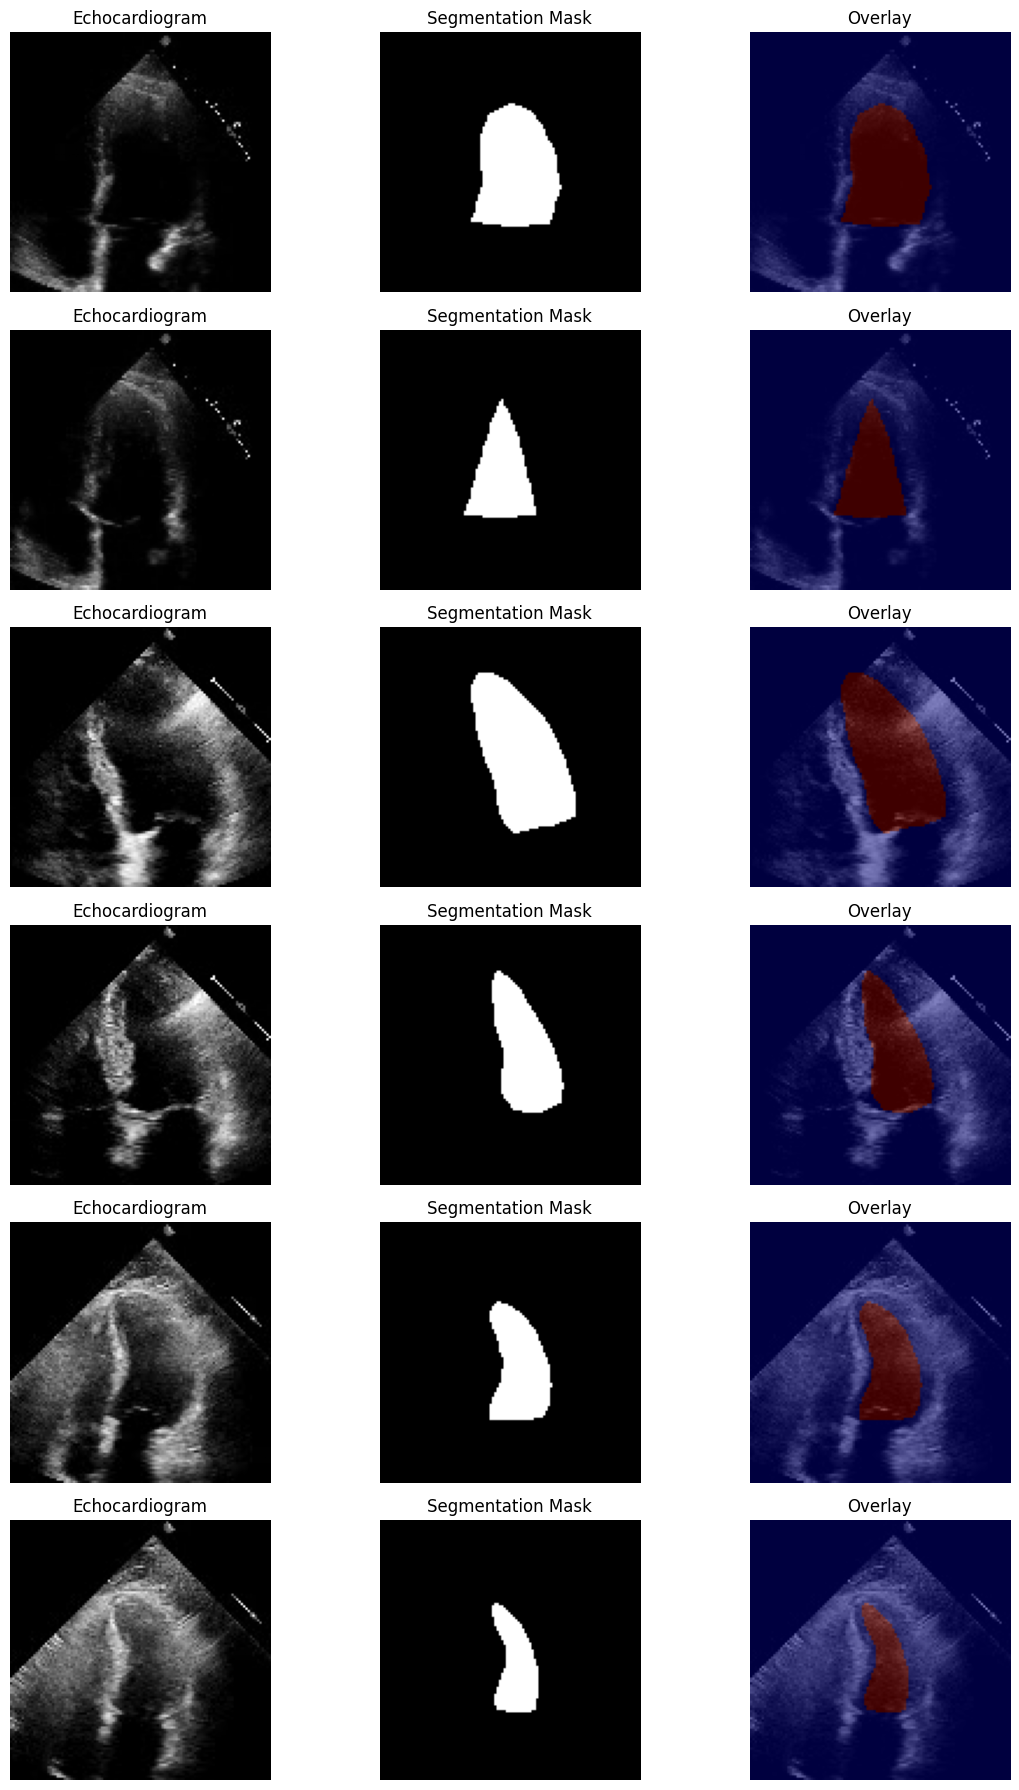

In [5]:
import matplotlib.pyplot as plt

def show_batch(loader, max_pairs=6):
    # get one complete batch from the DataLoader
    imgs, masks = next(iter(loader))  #(batch_size, 1, 112, 112)
    imgs, masks = imgs.cpu(), masks.cpu()  #move to CPU for matplotlib

    batch_size = imgs.size(0)
    n = min(max_pairs, batch_size)
    
    fig, axes = plt.subplots(n, 3, figsize=(12, 3*n))
    if n == 1:
        axes = axes.reshape(1, -1)

    for i in range(n):
        # Extract single image and mask from batch
        # Convert PyTorch tensors to numpy arrays for matplotlib
        img  = imgs[i, 0].numpy()   # (112, 112) echocardiogram
        mask = masks[i, 0].numpy()  # (112, 112)segmentation mask

        #col1 original echocardiogram frame
        axes[i][0].imshow(img, cmap="gray")# ultrasound
        axes[i][0].set_title("Echocardiogram") 
        axes[i][0].axis("off")

        # col2: Display the segmentation mask
        axes[i][1].imshow(mask, cmap="gray")
        axes[i][1].set_title("Segmentation Mask")
        axes[i][1].axis("off")

        # col 3: overlay - frame as background with colored mask on top
        axes[i][2].imshow(img, cmap="gray")   
        axes[i][2].imshow(mask, cmap="jet", alpha=0.5)  
        axes[i][2].set_title("Overlay")
        axes[i][2].axis("off")

    plt.tight_layout()
    plt.show()

# validation data - shows 6 frame-mask pairs with overlays
show_batch(val_loader, max_pairs=6)

## UNET and DoubleConv Class

In [6]:
import torch
import torch.nn as nn #imports necessary neural network toolbox
import torch.nn.functional as nnfunc 

class DoubleConv(nn.Module):
    """
    Double Convolution Block - Basic building block of U-Net
    Pattern: Conv -> BatchNorm -> ReLU -> Conv -> BatchNorm -> ReLU
    """
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),#the first convolution of the double conv.
            nn.BatchNorm2d(out_channels),
            # batch norm will help normalise the effects of activation functions
            # so that the model will be more stable and fast as per Geek4Geeks.
            nn.ReLU(inplace=True), # <- the activation function
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1), #second convolution
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, tensor):
        """
        This confused me initially, I thought that the code under def__init__
        would be enough, but according to Geeks4Geeks: 
        https://www.geeksforgeeks.org/deep-learning/understanding-the-forward-function-output-in-pytorch/
        
        The forward method is PyTorch's implementation of a forward pass:
        that's when the data/tensor is passed through the model
        """
        return self.double_conv(tensor)

class UNET(nn.Module):
    """
    U-Net Architecture for Medical Image Segmentation
    encoder (Downsampling):  Input -> Conv -> Pool -> Conv -> Pool -> bottleneck
    decoder (Upsampling):    bottleneck -> Upsample -> concat -> Conv -> ... -> Output
    skip connections: Connect encoder features directly to decoder for fine details
    """
    def __init__(self, in_channels, out_channels):
        super(UNET, self).__init__() 
        """
        A super().__init__() is necessary to initialise the base nn.Module 
        so that dependencies and everything works for neural networks in PyTorch
        
        Args:
            in_channels: number of input channels, 1 for grayscale
            out_channels: number of output channels, 1 for binary segmentation
            
        The U-Net paper has the following encoder implementation:
        1) Double conv (64 channels)
        2) Max pool 2x2 + Double conv (128 chnnels)  
        3) Max pool 2x2 + Double conv (256 chanels)
        4) Max pool 2x2 + Double conv (512 channls)
        5) Max pool 2x2 + Double conv (1024 chanels)
        
        Using this, there are 5 different double conv operations
        but we reuse the same max pool operation because the double conv
        has to account for changes in channel dimensions
        """
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)  # halves spatial dimensions
        
        # encoder path (contracting/downsampling)
        # each step: DoubleConv -> MaxPool (except bottleneck)
        self.dconv1 = DoubleConv(in_channels, 64)   # Input -> 64 channes   (128x128 -> 128x128)
        self.dconv2 = DoubleConv(64, 128)# 64 -> 128 channels     (64x64 -> 64x64)
        self.dconv3 = DoubleConv(128, 256) # 128 -> 256 chanels    (32x32 -> 32x32)
        self.dconv4 = DoubleConv(256, 512) # 256 -> 512 chanels    (16x16 -> 16x16)
        self.dconv5 = DoubleConv(512, 1024) # 512 -> 1024 chanels   (8x8 -> 8x8) bottleneck
        
        
        # decoder path (xpanding/upsampling)
        # these are the variables for the decoder - upsampling is the opposite of max pooling
        # Level 4: from bottleneck (1024 ch, 8x8) -> Level 4 encoder (512 ch, 16x16)
        self.upsample4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)# 8x8 -> 16x16
        self.upconv4 = DoubleConv(1024, 512)# 1024 channels (512+512 from skip) -> 512
        
        # Level 3: from level 4 (512 ch, 16x16) -> Level 3 encoder (256 ch, 32x32)  
        self.upsample3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)# 16x16 -> 32x32
        self.upconv3 = DoubleConv(512, 256)# 512 channels (256+256 from skip) -> 256
        
        # Level 2: from level 3 (256 ch, 32x32) -> Level 2 encoder (128 ch, 64x64)
        self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # 32x32 -> 64x64
        self.upconv2 = DoubleConv(256, 128)# 256 channels (128+128 from skip) -> 128
        
        # Level 1: from level 2 (128 ch, 64x64) -> Level 1 encoder (64 ch, 128x128)
        self.upsample1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)# 64x64 -> 128x128
        self.upconv1 = DoubleConv(128, 64) # 128 channels (64+64 from skip) -> 64
        
        # OUTPUT LAYER
        # after this the last step is one final 1x1 conv layer
        self.outconv = nn.Conv2d(64, 1, kernel_size=1)# 64 -> 1 channel (segmentation mask)
    
    def _concat(self, up_tensor, skip_tensor): 
        """
        concatenate upsampled tensor with skip connection from encoder.
        handle size mismatches by padding the smaller tensor.
        Skip connections are crucial because they:
        1.Preserve fine spatial details lost during downsampling
        2.Help gradients flow better during backpropagation  
        3.Combine low-level features (edges) with high-level features (semantics)
        """
        # Check if spatial dimensions match between upsampled and skip tensors
        if up_tensor.size(2) != skip_tensor.size(2) or up_tensor.size(3) != skip_tensor.size(3):
            # Calculate differences in hx and width
            y_ax_diff = skip_tensor.size(2) - up_tensor.size(2)  # height difference
            x_ax_diff = skip_tensor.size(3) - up_tensor.size(3)  # width difference

            # Pad order in F.pad = [left, right, top, bottom]
            # Distribute padding evenly, with extra pixels on right/bottom if odd
            up_tensor = nnfunc.pad(
                up_tensor,
                [x_ax_diff // 2, x_ax_diff - x_ax_diff // 2,   # [left, right]
                 y_ax_diff // 2, y_ax_diff - y_ax_diff // 2]   # [top, bottom]
            )
        
        # concatenate along channel dimension (dim=1)
        # noting that tensor format: [batch, channel, height, width]
        # result: channels = skip_channels + up_channels
        return torch.cat([skip_tensor, up_tensor], dim=1)
    
    def forward(self, tensor):
        '''
        Forward pass through U-Net
        Input -> encoder (extract features) -> bottleneck -> decoder (reconstruct) -> output
        skip connections preserve spatial information lost during downsampling
        input tensor shape: (batch_size, channels, height, width)
        echocardiograms frames: (batch_size, 1, 112, 112)
        '''
        # encoder path (steps 1-9) - Extract features at multiple scales
        # save encoder outputs for skip connections (step1, step3, step5, step7)
        step1 = self.dconv1(tensor) # Input(B,1,112,112) -> (B,64,112,112)
        step2 = self.max_pool(step1) # (B,64,112,112) -> (B,64,56,56)
        
        step3 = self.dconv2(step2)  # (B,64,56,56) -> (B,128,56,56)  
        step4 = self.max_pool(step3)  # (B,128,56,56) -> (B,128,28,28)
        
        step5 = self.dconv3(step4) # (B,128,28,28) -> (B,256,28,28)
        step6 = self.max_pool(step5) # (B,256,28,28) -> (B,256,14,14)
        
        step7 = self.dconv4(step6)   # (B,256,14,14) -> (B,512,14,14)
        step8 = self.max_pool(step7)   # (B,512,14,14) -> (B,512,7,7)
        
        step9 = self.dconv5(step8) # (B,512,7,7) -> (B,1024,7,7) bottleneck
        
        
        # decoder PATH - Reconstruct spatial resolution with skip connections
        # Each step: Upsample -> concatenate with encoder -> rocess with DoubleConv
        # Level 4: combine bottleneck with encoder level 4 (step7)
        step10 = self.upsample4(step9) # (B,1024,7,7) -> (B,512,14,14)
        step11 = self._concat(step10, step7)# concat: (B,512,14,14) + (B,512,14,14) -> (B,1024,14,14)
        step12 = self.upconv4(step11)    # (B,1024,14,14) -> (B,512,14,14)

        # Level 3: combine with encoder level 3 (step5) 
        step13 = self.upsample3(step12)# (B,512,14,14) -> (B,256,28,28)
        step14 = self._concat(step13, step5) # concat: (B,256,28,28) + (B,256,28,28) -> (B,512,28,28)
        step15 = self.upconv3(step14) # (B,512,28,28) -> (B,256,28,28)

        # Level 2: combine with encoder level 2 (step3)
        step16 = self.upsample2(step15)# (B,256,28,28) -> (B,128,56,56)
        step17 = self._concat(step16, step3) # concat: (B,128,56,56) + (B,128,56,56) -> (B,256,56,56)
        step18 = self.upconv2(step17) # (B,256,56,56) -> (B,128,56,56)

        # Level 1:final upsampling to original resolution, combine with step1
        step19 = self.upsample1(step18) # (B,128,56,56) -> (B,64,112,112)
        step20 = self._concat(step19, step1) # concat: (B,64,112,112) + (B,64,112,112) -> (B,128,112,112)
        step21 = self.upconv1(step20) # (B,128,112,112) -> (B,64,112,112)

        # output - Map feature channels to segmentation mask
        # returns raw logits (before sigmoid) - loss function will handle this
        return self.outconv(step21)# (B,64,112,112) -> (B,1,112,112) #back to original dimensions

## Model Training Loop


### Training Setup: Loss

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def dice_coeff(predictions, targets, smooth=1e-6):
    """
    no dice loss function in pytorch
    args:
        predictions: Sigmoid probabilities [0,1] 
        targets: Binary ground truth [0,1]
        smooth: Smoothing factor to avoid division by zero
    returns:
        dice_score: Float between 0 and 1
    """
    batch_size = predictions.size(0) #gets the first dim of (B,1,112,112) = B
    dice_scores = []
    
    for i in range(batch_size):
            # calc Dice for each image individually
            pred = predictions[i].reshape(-1)  # (1×112×112) → (12,544)
            target = targets[i].reshape(-1)  
            
            intersection = (pred * target).sum()
            dice = (2.0 * intersection + smooth) / (pred.sum() + target.sum() + smooth)
            dice_scores.append(dice)
        
        # Return average Dice across all images in batch
    return torch.stack(dice_scores).mean()


def CombinedBCEDiceLoss(predictions, targets, bce_weight=0.5, dice_weight=0.5):
    '''
    Combined BCE + Dice Loss for binary segmentation
    args:
        1.predictions (torch.Tensor): the raww model outputs (logits) from U-Net
            - expecting shape: (batch_size, 1, height, width) 
        2.targets (torch.Tensor): the ground truth binary masks
            - shape: (batch_size, 1, height, width) - same as predictions
        3. bce_weight (float):weighting for the bce component, set to 0.5 for equal weight with dice
            - BCE is good at: sharp boundaries, overall pixel classification
        4. dice_weight (float): weighting for the dice component, set to 0.5
            - Dice is good at: handling clss imbalance, shape preservation
    returns:
        tuple: (combined_loss, bce_component, dice_component)
            - combined_loss (torch.Tensor): Weighted sum for backpropagation
            - bce_component (float): BCE loss value for monitoring
            - dice_component (float): Dice loss value for monitoring
    '''
    # BCE part
    bce_loss = nn.BCEWithLogitsLoss()(predictions, targets)
    # Dice part
    predictions_sigmoid = torch.sigmoid(predictions)  #using sigmoid function to perform binary classification of the pixels
    dice_score = dice_coeff(predictions_sigmoid, targets) #compares the predictions agains the ground truth
    dice_loss = 1.0 - dice_score
    # Combined loss
    combined_loss = (bce_weight * bce_loss) + (dice_weight * dice_loss)
    
    return combined_loss, bce_loss.item(), dice_loss.item()


###  Training Setup : Device, initialising model, optimiser, and scheduler

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}")

# create the model and the params
model = UNET(in_channels=1, out_channels=1).to(device)

#variables
EPOCHS = 30 # number of epochs for cosine annealing
PATIENCE = 8 # patience is used for early stopping, preventing overfitting
SAVE_PATH = "best_unet_adamw_cosine.pt"  # weights

optimiser = torch.optim.AdamW(
    model.parameters(), 
    lr=0.001, # learning rate
    weight_decay=1e-4,# default weight decay 
    betas=(0.9, 0.999),# default momentum parameters
    eps=1e-8  #  numerical stability, default param set
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimiser,
    T_max=EPOCHS,# max num of epochs
    eta_min=1e-6, # minimum learning rate
    last_epoch=-1 # index of last epoch , default is -1
)



Training on: cuda


### Model Training function to train 1 epoch

In [ ]:
from tqdm import tqdm
import torch

def train_one_epoch(model, dataloader, optimizer, device, is_training=True):
    """
    function to train 1 epoch: used for the wandb training -- can be used for training/val
    args:
        model: U-Net model
        dataloader: PyTorch DataLoader (train_loader or val_loader)
        optimizer: PyTorch optimizer (only used if is_training=True)
        device: GPU/CPU device
        is_training: If True, performs training; if False, performs validation
    Returns:
        dict: {'combined_loss': float, 'bce_loss': float, 'dice_loss': float}
    """
    
    # Set model mode
    model.train() if is_training else model.eval()
    
    #loss/ metrics
    running_metrics = {
        'combined_loss': 0.0,
        'bce_loss': 0.0, 
        'dice_loss': 0.0
    }
    num_batches = 0
    
    #progress bar -> from Chat GPT
    phase = "Training" if is_training else "Validation"
    progress_bar = tqdm(dataloader, desc=phase, leave=False)
    
    # train/val loop
    with torch.set_grad_enabled(is_training): #only compute gradients if training 
        for batch_images, batch_masks in progress_bar:
            #move to GPU to utilise cuda for tensor calculations
            batch_images = batch_images.to(device, non_blocking=True)
            batch_masks = batch_masks.to(device, non_blocking=True)
            
            '''using DataCamp's guide to training loop of 
            1.Zeroing the gradients: pytorch gradient results accumulate by default
            if the gradients aren't zeroed then it adds up per batch, so the calculations
            would be wrong'''
            if is_training:
                optimizer.zero_grad()
            
            '''2.Forward Pass: the input tensor goes through the unet model
            to generate an output'''
            predictions = model(batch_images)
            
            #3. Calc Loss: uses BCE and DICE loss
            combined_loss, bce_loss, dice_loss = CombinedBCEDiceLoss(
                predictions, batch_masks, bce_weight=0.5, dice_weight=0.5
            )
            
            #4.Backward pass: backprop occurs only used during training
            if is_training:
                combined_loss.backward() #computes error contribution for each weight
                optimizer.step() #changes weight to reduce error
            
            #5. Keep track of loss
            running_metrics['combined_loss'] += combined_loss.item()
            running_metrics['bce_loss'] += bce_loss
            running_metrics['dice_loss'] += dice_loss
            num_batches += 1
            
            # Update progress bar
            progress_bar.set_postfix({
                'Loss': f'{combined_loss.item():.4f}',
                'BCE': f'{bce_loss:.4f}',
                'Dice': f'{dice_loss:.4f}'
            })
    
    # Calculate averages
    avg_metrics = {
        key: value / num_batches 
        for key, value in running_metrics.items()
    }
    
    return avg_metrics

### Below is training without weights and biases

In [ ]:
import time 

def train_model():
    best_val_loss = float('inf')
    patience_counter = 0 # keep track of how many epochs have passed since improvement
    best_epoch = 0 # to keep track of the epoch where the model performed best
    training_log = {
        'train_loss': [], #keep track of the combined loss during training
        'train_bce': [], #track bce loss during trianing
        'train_dice': [], #track dice loss during trianing
        'val_loss': [], #keep track of loss for val
        'val_bce': [],
        'val_dice': [],
        'learning_rates': [] #learning rate set per epoch
    }
    for epoch in range(EPOCHS):
        epoch_start_time = time.time()
        #training phase
        train_loss, train_bce, train_dice = train_one_epoch(train_loader, is_training=True)
        #validation phase after training
        val_loss, val_bce, val_dice = train_one_epoch(val_loader,is_training= False)
        scheduler.step()
        current_lr = optimiser.param_groups[0]['lr']
        
        training_log['train_loss'].append(train_loss)
        training_log['train_bce'].append(train_bce)
        training_log['train_dice'].append(train_dice)
        training_log['val_loss'].append(val_loss)
        training_log['val_bce'].append(val_bce)
        training_log['val_dice'].append(val_dice)
        training_log['learning_rates'].append(current_lr)
        epoch_time = time.time() - epoch_start_time
        #print the important results: training time, metrics per epoch --- ChatGPT code, not mine
        print(f"Epoch {epoch+1:2d}/{EPOCHS} ({epoch_time:.1f}s) | "
              f"LR: {current_lr:.2e} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f}")
    
        if val_loss < best_val_loss: #checks if the current val_loss is better than the best val_loss
            best_val_loss = val_loss #if it is then update the best loss score
            patience_counter = 0 #reset the patience counter, because there's been an improvement
            best_epoch = epoch +1
            
            # Save best model
            torch.save({
                'epoch': epoch,
                'best_epoch': best_epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimiser.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_loss': val_loss,
                'train_loss': train_loss,
                'training_log': training_log
            }, SAVE_PATH)
            #print a checkpoint to flag the best epoch
            print(f"Best model based on val loss, Epoch: {best_epoch}")
        else:
            patience_counter +=1 #adds to the patience counter if no improvement
        #check if the patient counter is above the threshold set
        if patience_counter >= PATIENCE:
            print("Training stopped: no improvement in loss")
            break 
    
    print(f"Training complete. Best val loss: {best_val_loss:4f}") # <- CHAT GPT code
    print(f"Best epoch: {best_epoch}")
    print(f"Model saved in: {SAVE_PATH}")

    return training_log


#### Trigger Model Training without weights and biases

In [16]:
#history = train_model()

### Train with Weights and Biases:

In [9]:
import os
import wandb
import time

os.environ["WANDB_API_KEY"] = "eb3e09cf1d43280600e84da34e183ab422135213"
wandb.login()

wandb: Currently logged in as: jocena (jocena-nsw-health) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
def train_model_with_wandb():
   #initialisew the wandb
    wandb.init(
        project="unet-echocardiogram-segmentation",
        name=f"adamw-cosine-{EPOCHS}epochs",
        config={
            "epochs": EPOCHS,
            "batch_size": BATCH_SIZE,
            "learning_rate": 0.001,
            "patience": PATIENCE,
            "architecture": "U-Net",
            "optimizer": "AdamW",
            "scheduler": "CosineAnnealingLR",
            "loss": "BCE+Dice",
            "dataset": "EchoNet-Dynamic"
        }
    )
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_epoch = 0
    training_log = {
        'train_loss': [],
        'train_bce': [],
        'train_dice': [],
        'val_loss': [],
        'val_bce': [],
        'val_dice': [],
        'learning_rates': []
    }
    
    for epoch in range(EPOCHS):
        epoch_start_time = time.time()
        
        # Training and validation - FIX THE FUNCTION CALLS
        train_metrics = train_one_epoch(model, train_loader, optimiser, device, is_training=True)
        val_metrics = train_one_epoch(model, val_loader, optimiser, device, is_training=False)
        
        scheduler.step()
        current_lr = optimiser.param_groups[0]['lr']
        
        # CALCULATE EPOCH TIME HERE - BEFORE LOGGING
        epoch_time = time.time() - epoch_start_time
        
        # Extract values from dictionaries
        train_loss = train_metrics['combined_loss']
        train_bce = train_metrics['bce_loss']
        train_dice = train_metrics['dice_loss']
        
        val_loss = val_metrics['combined_loss']
        val_bce = val_metrics['bce_loss']
        val_dice = val_metrics['dice_loss']
        
        # Log to local history (keep your existing code)
        training_log['train_loss'].append(train_loss)
        training_log['train_bce'].append(train_bce)
        training_log['train_dice'].append(train_dice)
        training_log['val_loss'].append(val_loss)
        training_log['val_bce'].append(val_bce)
        training_log['val_dice'].append(val_dice)
        training_log['learning_rates'].append(current_lr)

        # NOW LOG TO W&B WITH EPOCH_TIME DEFINED
        wandb.log({
            "epoch": epoch + 1,
            "train/combined_loss": train_loss,
            "train/bce_loss": train_bce,
            "train/dice_loss": train_dice,
            "val/combined_loss": val_loss,
            "val/bce_loss": val_bce,
            "val/dice_loss": val_dice,
            "learning_rate": current_lr,
            "epoch_time_seconds": epoch_time
        })
        
        # Print epoch results
        print(f"Epoch {epoch+1:2d}/{EPOCHS} ({epoch_time:.1f}s) | "
              f"LR: {current_lr:.2e} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f}")
        
        # save model if val loss < best val loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_epoch = epoch + 1
            
            # Save model
            torch.save({
                'epoch': epoch,
                'best_epoch': best_epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimiser.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_loss': val_loss,
                'train_loss': train_loss,
                'training_log': training_log
            }, SAVE_PATH)
            
            # Log best metrics to W&B
            wandb.log({
                "best_val_loss": best_val_loss,
                "best_epoch": best_epoch
            })
            
            print(f"Best model saved @ epoch: {best_epoch}")
        else:
            patience_counter += 1
            
        if patience_counter >= PATIENCE:
            print("Early stopping triggered since no improvement")
            wandb.log({
                "early_stopped": True,
                "stopped_at_epoch": epoch + 1
            })
            break
    
    # Final summary
    print(f"Training complete. Best val loss: {best_val_loss:.4f}")
    print(f"View W&B dashboard: {wandb.run.url}")
    
    # Close W&B run
    wandb.finish()
    
    return training_log


#### Trigger Training using weights and biases

In [17]:
'''Trigger Training with weights and biases'''
history_wandb = train_model_with_wandb()

Epoch  1/30 (120.8s) | LR: 9.76e-04 | Train Loss: 0.0675 | Val Loss: 0.0728
Best model saved @ epoch: 1


Epoch  2/30 (119.5s) | LR: 9.57e-04 | Train Loss: 0.0646 | Val Loss: 0.0668
Best model saved @ epoch: 2


Epoch  3/30 (119.9s) | LR: 9.33e-04 | Train Loss: 0.0626 | Val Loss: 0.0649
Best model saved @ epoch: 3


Epoch  4/30 (119.5s) | LR: 9.05e-04 | Train Loss: 0.0612 | Val Loss: 0.0655


Epoch  5/30 (120.1s) | LR: 8.72e-04 | Train Loss: 0.0598 | Val Loss: 0.0661


Epoch  6/30 (120.2s) | LR: 8.35e-04 | Train Loss: 0.0590 | Val Loss: 0.0642
Best model saved @ epoch: 6


Epoch  7/30 (120.0s) | LR: 7.94e-04 | Train Loss: 0.0572 | Val Loss: 0.0645


Epoch  8/30 (119.9s) | LR: 7.50e-04 | Train Loss: 0.0560 | Val Loss: 0.0631
Best model saved @ epoch: 8


Epoch  9/30 (119.6s) | LR: 7.04e-04 | Train Loss: 0.0546 | Val Loss: 0.0647


Epoch 10/30 (119.8s) | LR: 6.55e-04 | Train Loss: 0.0529 | Val Loss: 0.0669


Epoch 11/30 (121.4s) | LR: 6.04e-04 | Train Loss: 0.0513 | Val Loss: 0.0643


Epoch 12/30 (119.7s) | LR: 5.53e-04 | Train Loss: 0.0494 | Val Loss: 0.0650


Epoch 13/30 (120.2s) | LR: 5.01e-04 | Train Loss: 0.0476 | Val Loss: 0.0670


Epoch 14/30 (119.8s) | LR: 4.48e-04 | Train Loss: 0.0451 | Val Loss: 0.0666


Epoch 15/30 (120.9s) | LR: 3.97e-04 | Train Loss: 0.0429 | Val Loss: 0.0670


Epoch 16/30 (121.1s) | LR: 3.46e-04 | Train Loss: 0.0405 | Val Loss: 0.0697
Early stopping triggered since no improvement
Training complete. Best val loss: 0.0631
View W&B dashboard: https://wandb.ai/jocena-nsw-health/unet-echocardiogram-segmentation/runs/zdfvuw13


best_epoch,▁▂▃▆█
best_val_loss,█▄▂▂▁
epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
epoch_time_seconds,▆▁▂▁▃▃▃▂▁▂█▂▃▂▆▇
learning_rate,███▇▇▆▆▅▅▄▄▃▃▂▂▁
stopped_at_epoch,▁
train/bce_loss,█▇▇▆▆▆▅▅▄▄▄▃▃▂▂▁
train/combined_loss,█▇▇▆▆▆▅▅▅▄▄▃▃▂▂▁
train/dice_loss,█▇▇▆▆▆▅▅▅▄▄▃▃▂▂▁
val/bce_loss,▅▂▂▂▂▁▂▁▂▄▃▄▅▅▆█
+2,...


## Test Model Performance <- ensure Dataloader cells are activated first

In [19]:
#Import iou
from torchmetrics import JaccardIndex

# load model:
def load_trained_model(path="best_unet_adamw_cosine.pt"): 
    """Load the trained U-Net model from checkpoint"""
    model = UNET(1, 1).to(device)
    
    if os.path.exists(path):  # Check if model exists
        try:
            checkpoint = torch.load(path, map_location=device, weights_only=False)
            model.load_state_dict(checkpoint['model_state_dict'])
            print("Model loaded")
            model.eval()
            return model, checkpoint
        except Exception as e:
            print("Model not loaded")
            return None, None
    else:
        print("Error")
        return None, None


# Test the function
loaded_model, checkpoint_info = load_trained_model()

def test_model(model, test_loader, device):
    """
    Test the trained model on test data using BCE+Dice loss + TorchMetrics mIoU
    args:
        model: trained U-Net model
        test_loader: DataLoader containing test data
        device: GPU or CPU device
    
    returns:
        dict: Dictionary containing all test metrics
    """
    #set to eval mode
    model.eval()
    
    #inclue iou as a metric
    iou = JaccardIndex(task='binary', num_classes=2).to(device)
    
    #track metrics
    total_loss = 0.0
    total_bce = 0.0
    total_dice_loss = 0.0
    num_batches = 0
    
    # no backprop
    with torch.no_grad():
        #loop through batches
        for images, masks in tqdm(test_loader, desc="Testing"):
            #move to GPU
            images = images.to(device)
            masks = masks.to(device)
            
            #perform predictions
            predictions = model(images)
            
            #calculate loss
            combined_loss, bce_loss, dice_loss = CombinedBCEDiceLoss(predictions, masks)
            
            #use sigmoid function for binary pred
            predictions_sigmoid = torch.sigmoid(predictions) #converts the logits to [0,1]
            predictions_binary = (predictions_sigmoid > 0.5).long() #use threshold of 0.5
            masks_binary = masks.long()
            
            iou.update(predictions_binary, masks_binary)
            
            total_loss += combined_loss.item()
            total_bce += bce_loss
            total_dice_loss += dice_loss
            num_batches += 1
    
    #get iou score for every batch
    final_iou = iou.compute()
    
    #average metrics across all test batches
    avg_loss = total_loss / num_batches
    avg_bce = total_bce / num_batches  
    avg_dice_loss = total_dice_loss / num_batches
    dice_score = 1 - avg_dice_loss
    
    # Print results
    print(f"\nTest Results:")
    print(f"   Combined Loss (BCE+Dice):  {avg_loss:.4f}")
    print(f"   BCE Component:             {avg_bce:.4f}")
    print(f"   Dice Loss:                 {avg_dice_loss:.4f}")
    print(f"   Dice Score:                {dice_score:.4f}")
    print(f"   mIoU (TorchMetrics):       {final_iou:.4f}")
    
    # Reset metric for next use
    iou.reset()
    
    # Return dictionary with all metrics
    return {
        'combined_loss': avg_loss,
        'bce_loss': avg_bce,
        'dice_loss': avg_dice_loss,
        'dice_score': dice_score,
        'miou_score': final_iou.item()  # Convert tensor to float
    }

#run the test loop
if loaded_model is not None:
    test_metrics = test_model(loaded_model, test_loader, device)
else:
    print("Error statement here")

Model loaded


Testing: 100%|██████████| 377/377 [00:07<00:00, 52.90it/s]



Test Results:
   Combined Loss (BCE+Dice):  0.0637
   BCE Component:             0.0423
   Dice Loss:                 0.0851
   Dice Score:                0.9149
   mIoU (TorchMetrics):       0.8655


## Predicting one video folder

### Use the model to predict 1 folder's worth of frame

In [12]:
#make sure to load the trained model first
#trrain on the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

import cv2 
import numpy as np

def predict_one(model, folder, threshold =0.5):
    '''use this to predict 1 folder first to see the results, and prototype the video output
    
    args: 
        model: UNET(in_chan, out_chan)
        folder: the path to the folder for prediction-- use test folder instead of train/val
        threshold: threshold for binary pred set to 0.5
        
    returns: a dictionary called predictions
        frame: framename relating to the predicted frame
        frame_image: the original frame image
        mask: binary mask as numpy arrays (just like how original segmentation mask was created
        pixel_count: pixel count for the mask
        '''

    folder = Path(folder)
    frame_paths = sorted(folder.glob("*.png")) #look for .png files in the specified folder
    
    predictions = {
        'frame': [],           # framename 
        'frame_image': [],     # frameimage
        'mask': [],            # binary mask
        'pixel_count': []      # pixel count for the mask
    }
    model.eval()
    
    with torch.no_grad(): #disable backprop
        for frame_path in frame_paths:
            try:
                #loading the oriignal frame
                frame = cv2.imread(str(frame_path), cv2.IMREAD_GRAYSCALE) #specifying that it's grayscale
                
                '''turn each frame to a tensor of the expected shape (Batch, 1, 112, 112) but since not using dataloader
                just change the B = 1'''
                #Normalise to [0,1] for gradient stability, and to help the sgimoid act function to work with the threshold of 0.5
                frame_normalised = frame.astype(np.float32)/255.0
                frame_tensor = torch.from_numpy(frame_normalised) #creates tensor shape (112, 112) corresp to H*W
                frame_tensor = frame_tensor.unsqueeze(0) #add channel dim, = 1 so shape is (1,112,112)
                '''initially just had a tensor shape (1,112,112) but kept getting errors,
                so chatgpt was used, and troubleshooted that my model was coded with the tensor shape (B, 1, 112,112) 
                in mind cause the model used a dataloader'''
                frame_tensor = frame_tensor.unsqueeze(0) #add batch dim, so shape is (1,1,112,112)
                frame_tensor =frame_tensor.to(device) #use GPU
                
                #run the model to output logits which are just raw numbers
                with torch.amp.autocast(device_type=device.type, enabled=(device.type=="cuda")):
                    logits = model(frame_tensor) #creates raw logits eg: [-2.1,  0.0,  3.4, -0.5] 
                    probs = torch.sigmoid(logits) # after sigmoid it changes this to [0,1] eg. [0.11, 0.50, 0.97, 0.38]
                    binary_mask = (probs > threshold).float() #apply the 0.5 threshold
                
                '''
                initially, i just squeezed the tensor to remove the channel dim, but
                kept getting error, so 
                mask_np = binary_mask.squeeze().numpy()  <-- Kept getting error
                
                ChatGPT says to move tensors to the cpu before using np, and it worked
                '''
                mask_np = binary_mask.squeeze().cpu().numpy()  # Move to CPU first, then convert
                #calcualte the pix count for each frame
                pixel_count = int(np.sum(mask_np))
                
                #store the result of each frame in frame_path in the dict.
                predictions['frame'].append(frame_path.name)         # filename
                predictions['frame_image'].append(frame)     # original image (112x112)
                predictions['mask'].append(mask_np)                  # binary mask (112x112)
                predictions['pixel_count'].append(pixel_count)       # pix count for later
            
            except Exception:
                print("error")
                break
            
    return predictions

Using: cuda


In [13]:
test_folder=  "EchoNet-Dynamic\\frame_outputs\\0X1A2A76BDB5B98BED"
predictions = predict_one(loaded_model, test_folder, threshold=0.5)

### Code to visualise predictions - this was created using ChatGPT via prompts 
 none of the code below is my work. This was completed by giving chatGPT the following prompt:
'create a function w/ args: prediction '''visualise and save prediction frames individually for video creation
    args:
        predictions: the dictionary from predict_one()
        num_visualise: number of frames to display in grid (None = display all)
        save_dir: where to save individual frame files for video creation
    '''

In [14]:
def visualise_predictions(predictions, num_visualise=None, save_dir=None):
    '''visualise and save prediction frames individually for video creation
    args:
        predictions: the dictionary from predict_one()
        num_visualise: number of frames to display in grid (None = display all)
        save_dir: where to save individual frame files for video creation
    '''
    
    if not predictions or len(predictions['frame']) == 0:
        print("No predictions to visualize!")
        return
    
    # If save_dir is provided, save ALL frames individually (not just displayed ones)
    if save_dir:
        save_path = Path(save_dir)
        save_path.mkdir(exist_ok=True)
        
        # Create subdirectories for different types  
        (save_path / "original").mkdir(exist_ok=True)
        (save_path / "masks").mkdir(exist_ok=True)
        (save_path / "overlays").mkdir(exist_ok=True)
        
        print(f"Saving {len(predictions['frame'])} individual frames...")
        
        # Save ALL frames in the folder (not just num_visualise)
        for i in range(len(predictions['frame'])):
            frame = predictions['frame_image'][i]
            mask = predictions['mask'][i]
            frame_name = predictions['frame'][i]
            pixel_count = predictions['pixel_count'][i]
            
            # Remove .png extension for cleaner naming
            base_name = frame_name.replace('.png', '')
            
            # Save original frame
            fig, ax = plt.subplots(1, 1, figsize=(4, 4))
            ax.imshow(frame, cmap='gray')
            ax.set_title(f'Frame: {frame_name}')
            ax.axis('off')
            plt.tight_layout()
            plt.savefig(save_path / "original" / f"{base_name}_original.png", 
                       dpi=150, bbox_inches='tight', pad_inches=0.1)
            plt.close()  # Important: close to free memory
            
            # Save predicted mask
            fig, ax = plt.subplots(1, 1, figsize=(4, 4))
            ax.imshow(mask, cmap='gray')
            ax.set_title(f'Mask: {pixel_count} pixels')
            ax.axis('off')
            plt.tight_layout()
            plt.savefig(save_path / "masks" / f"{base_name}_mask.png", 
                       dpi=150, bbox_inches='tight', pad_inches=0.1)
            plt.close()
            
            # Save overlay
            fig, ax = plt.subplots(1, 1, figsize=(4, 4))
            ax.imshow(frame, cmap='gray')
            ax.imshow(mask, cmap='jet', alpha=0.5)
            ax.set_title(f'Heart Segmentation')
            ax.axis('off')
            plt.tight_layout()
            plt.savefig(save_path / "overlays" / f"{base_name}_overlay.png", 
                       dpi=150, bbox_inches='tight', pad_inches=0.1)
            plt.close()
            
            # Progress indicator every 10 frames
            if (i + 1) % 10 == 0:
                print(f"Saved {i + 1}/{len(predictions['frame'])} frames")
        
        print(f"\nAll individual frames saved to:")
        print(f"  Original: {save_path / 'original'}")
        print(f"  Masks: {save_path / 'masks'}")
        print(f"  Overlays: {save_path / 'overlays'}")
    
    # Display grid visualization (original functionality)
    if num_visualise is None:
        num_visualise = min(8, len(predictions['frame']))  # Default to 8 if not specified
    
    num = min(num_visualise, len(predictions['frame']))
    
    if num > 0:
        print(f"\nDisplaying {num} frames in grid...")
        
        # Handle single frame case
        if num == 1:
            fig, axes = plt.subplots(1, 3, figsize=(15, 4))
            axes = axes.reshape(1, -1)
        else:
            fig, axes = plt.subplots(num, 3, figsize=(15, 4*num))
        
        for i in range(num):
            frame = predictions['frame_image'][i]
            mask = predictions['mask'][i]
            frame_name = predictions['frame'][i]
            pixel_count = predictions['pixel_count'][i]
            
            # Column 1: Original frame
            axes[i, 0].imshow(frame, cmap='gray')
            axes[i, 0].set_title(f'Original Frame\n{frame_name}')
            axes[i, 0].axis('off')
            
            # Column 2: Predicted mask
            axes[i, 1].imshow(mask, cmap='gray')
            axes[i, 1].set_title(f'Predicted Mask\nPixels: {pixel_count}')
            axes[i, 1].axis('off')
            
            # Column 3: Overlay
            axes[i, 2].imshow(frame, cmap='gray')
            axes[i, 2].imshow(mask, cmap='jet', alpha=0.5)
            axes[i, 2].set_title('Heart Segmentation\nOverlay')
            axes[i, 2].axis('off')
        
        # Save grid visualization if save_dir provided
        if save_dir:
            grid_filename = save_path / f"grid_visualization_{num}_samples.png"
            plt.savefig(grid_filename, dpi=300, bbox_inches='tight')
            print(f"Grid visualization saved: {grid_filename}")
        
        plt.tight_layout()
        plt.show()
    

### Run Visualisation for 1 folder's worth of frames

Saving 201 individual frames...
Saved 10/201 frames
Saved 20/201 frames
Saved 30/201 frames
Saved 40/201 frames
Saved 50/201 frames
Saved 60/201 frames
Saved 70/201 frames
Saved 80/201 frames
Saved 90/201 frames
Saved 100/201 frames
Saved 110/201 frames
Saved 120/201 frames
Saved 130/201 frames
Saved 140/201 frames
Saved 150/201 frames
Saved 160/201 frames
Saved 170/201 frames
Saved 180/201 frames
Saved 190/201 frames
Saved 200/201 frames

All individual frames saved to:
  Original: test_one_video\original
  Masks: test_one_video\masks
  Overlays: test_one_video\overlays

Displaying 8 frames in grid...
Grid visualization saved: test_one_video\grid_visualization_8_samples.png


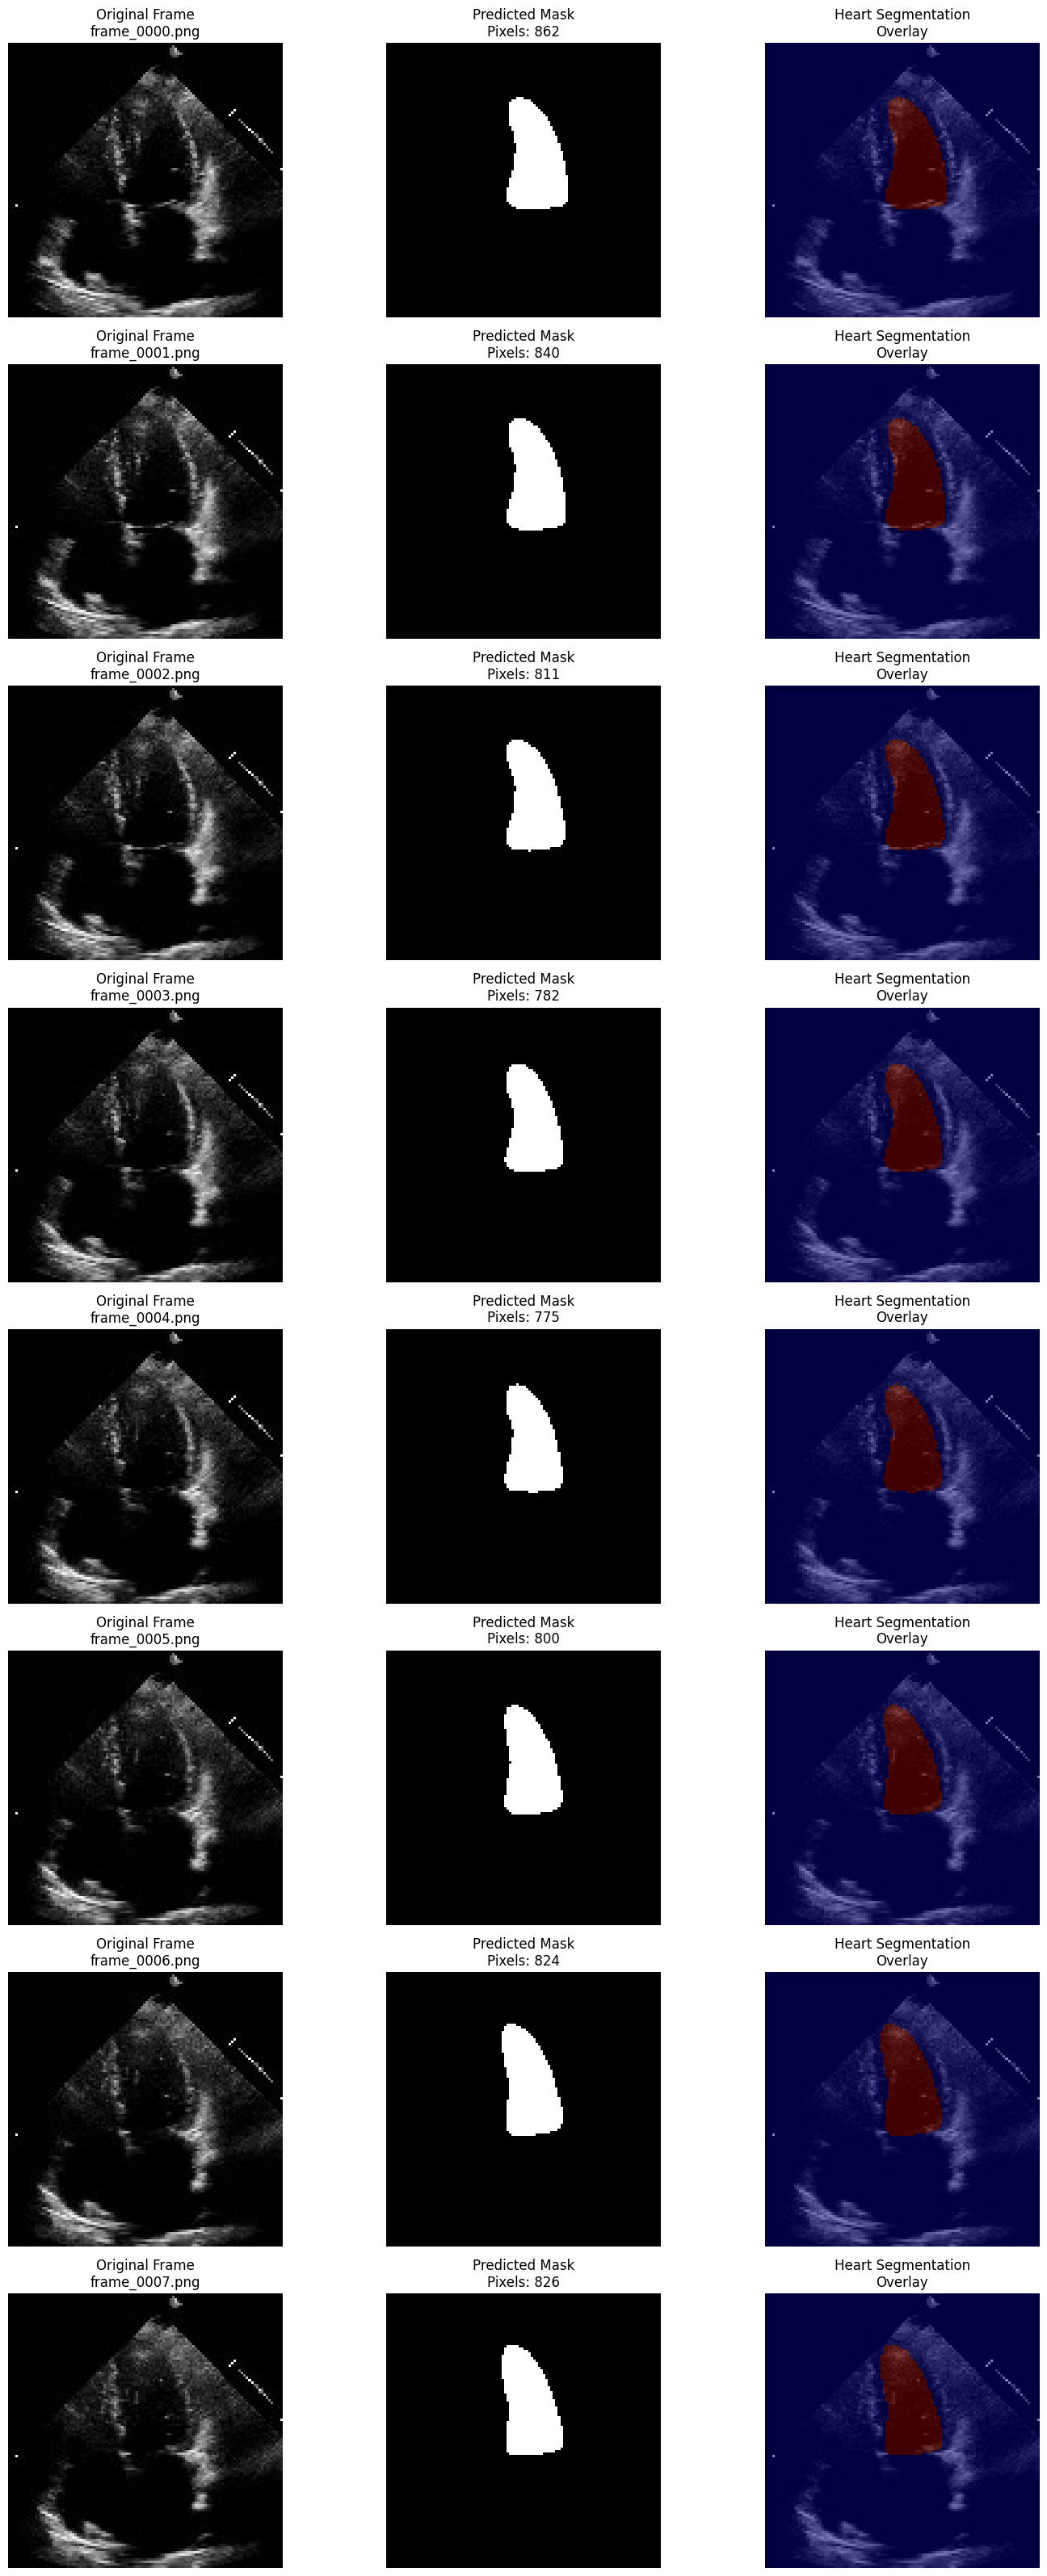

In [ ]:
vis_save_dir = "test_one_video" #folder to save one test video
visualise_predictions(predictions, 8, save_dir=vis_save_dir)